## Implementazione HNKPC

### Step 1: Import librerie e caricamento dati

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Caricamento dati FRED
compensation = pd.read_csv('/Users/tommaso/Desktop/tesi-inflation-gt/HNKPC/FRED_data/ITACOMPQDSNAQ.csv')
gdp_nominal = pd.read_csv('/Users/tommaso/Desktop/tesi-inflation-gt/HNKPC/FRED_data/ITAGDPNQDSMEI.csv')

# Caricamento NIC destagionalizzato
nic_data = pd.read_csv('/Users/tommaso/Desktop/tesi-inflation-gt/Destagionalized_Indexes/dati_preparati_fase1/nic_fase1.csv')

# Caricamento indici GT (dovrebbero essere i destagionalizzati)
gt_data = pd.read_csv('/Users/tommaso/Desktop/tesi-inflation-gt/Destagionalized_Indexes/dati_preparati_fase1/indici_gt_destag_fase1.csv')

print("Dati caricati:")
print(f"Compensation shape: {compensation.shape}")
print(f"GDP Nominal shape: {gdp_nominal.shape}")
print(f"NIC shape: {nic_data.shape}")
print(f"GT shape: {gt_data.shape}")

# Mostra prime righe per controllo
print("\nCompensation head:")
print(compensation.head())
print("\nGDP Nominal head:")
print(gdp_nominal.head())


Dati caricati:
Compensation shape: (81, 2)
GDP Nominal shape: (79, 2)
NIC shape: (252, 2)
GT shape: (252, 12)

Compensation head:
  observation_date  ITACOMPQDSNAQ
0       2004-01-01   1.334403e+11
1       2004-04-01   1.369658e+11
2       2004-07-01   1.364731e+11
3       2004-10-01   1.378461e+11
4       2005-01-01   1.396434e+11

GDP Nominal head:
  observation_date  ITAGDPNQDSMEI
0       2004-01-01   3.568374e+11
1       2004-04-01   3.628947e+11
2       2004-07-01   3.627257e+11
3       2004-10-01   3.673258e+11
4       2005-01-01   3.670997e+11


### Step 2: Pulizia e preparazione dati FRED

In [2]:
# Rinomina colonne per chiarezza
compensation.columns = ['DATE', 'COMPENSATION']
gdp_nominal.columns = ['DATE', 'GDP_NOMINAL']

# Converti date
compensation['DATE'] = pd.to_datetime(compensation['DATE'])
gdp_nominal['DATE'] = pd.to_datetime(gdp_nominal['DATE'])

# Filtra periodo comune (2004Q1 - 2023Q3)
start_date = '2004-01-01'
end_date = '2023-09-30'  # Fine Q3 2023

compensation_filtered = compensation[
    (compensation['DATE'] >= start_date) & 
    (compensation['DATE'] <= end_date)
].copy()

gdp_filtered = gdp_nominal[
    (gdp_nominal['DATE'] >= start_date) & 
    (gdp_nominal['DATE'] <= end_date)
].copy()

print("Dati FRED filtrati:")
print(f"Compensation: {compensation_filtered.shape[0]} osservazioni")
print(f"Da {compensation_filtered['DATE'].min()} a {compensation_filtered['DATE'].max()}")
print(f"GDP: {gdp_filtered.shape[0]} osservazioni")
print(f"Da {gdp_filtered['DATE'].min()} a {gdp_filtered['DATE'].max()}")


Dati FRED filtrati:
Compensation: 79 osservazioni
Da 2004-01-01 00:00:00 a 2023-07-01 00:00:00
GDP: 79 osservazioni
Da 2004-01-01 00:00:00 a 2023-07-01 00:00:00


### Step 3: Calcolo Labor Share

Labor Share calcolata:
        DATE  LABOR_SHARE
0 2004-01-01    37.395267
1 2004-04-01    37.742574
2 2004-07-01    37.624326
3 2004-10-01    37.526931
4 2005-01-01    38.039639
5 2005-04-01    37.923868
6 2005-07-01    37.761513
7 2005-10-01    38.716862
8 2006-01-01    38.581549
9 2006-04-01    38.461704

Statistiche Labor Share:
Media: 39.46%
Min: 37.40%
Max: 41.21%
Std: 0.89%


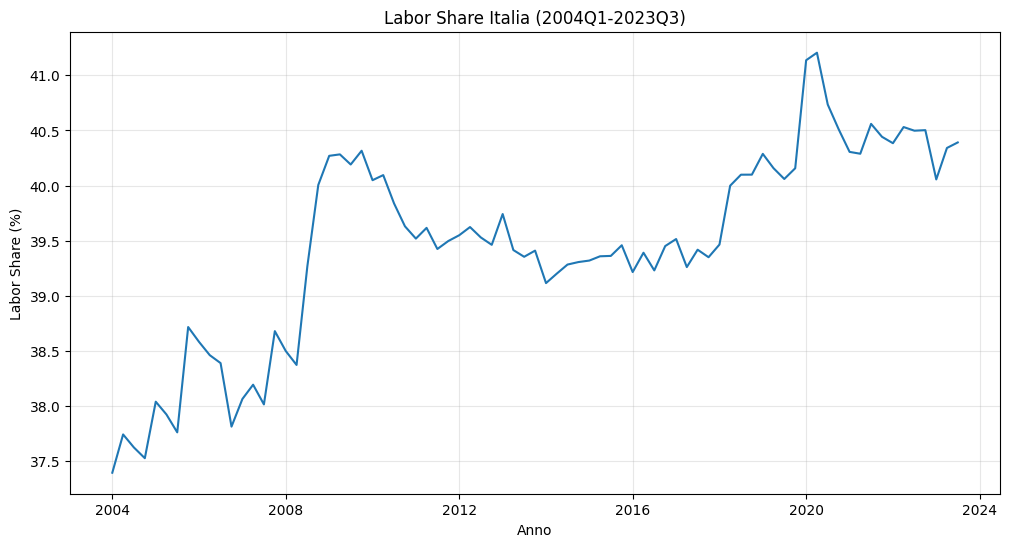

In [3]:
# Merge compensation e GDP
fred_data = pd.merge(compensation_filtered, gdp_filtered, on='DATE', how='inner')

# Calcola Labor Share
fred_data['LABOR_SHARE'] = (fred_data['COMPENSATION'] / fred_data['GDP_NOMINAL']) * 100

# Aggiungi info trimestre
fred_data['YEAR'] = fred_data['DATE'].dt.year
fred_data['QUARTER'] = fred_data['DATE'].dt.quarter

print("Labor Share calcolata:")
print(fred_data[['DATE', 'LABOR_SHARE']].head(10))

# Statistiche descrittive
print(f"\nStatistiche Labor Share:")
print(f"Media: {fred_data['LABOR_SHARE'].mean():.2f}%")
print(f"Min: {fred_data['LABOR_SHARE'].min():.2f}%")
print(f"Max: {fred_data['LABOR_SHARE'].max():.2f}%")
print(f"Std: {fred_data['LABOR_SHARE'].std():.2f}%")

# Plot Labor Share
plt.figure(figsize=(12, 6))
plt.plot(fred_data['DATE'], fred_data['LABOR_SHARE'])
plt.title('Labor Share Italia (2004Q1-2023Q3)')
plt.ylabel('Labor Share (%)')
plt.xlabel('Anno')
plt.grid(True, alpha=0.3)
plt.show()


### Step 4: Preparazione dati NIC per aggregazione quarterly

In [4]:
# Controlla struttura NIC
print("Struttura NIC:")
print(nic_data.head())
print(f"Colonne: {nic_data.columns.tolist()}")

# Converti data (assumendo che sia la prima colonna)
date_col = nic_data.columns[0]  # Prima colonna dovrebbe essere la data
nic_col = 'NIC_destag_ISTAT'  # Assumendo questo nome, adatta se diverso

nic_clean = nic_data[[date_col, nic_col]].copy()
nic_clean.columns = ['DATE', 'NIC']
nic_clean['DATE'] = pd.to_datetime(nic_clean['DATE'])

# Filtra stesso periodo FRED
nic_clean = nic_clean[
    (nic_clean['DATE'] >= start_date) & 
    (nic_clean['DATE'] <= end_date)
].copy()

print(f"NIC filtrato: {nic_clean.shape[0]} osservazioni")
print(f"Da {nic_clean['DATE'].min()} a {nic_clean['DATE'].max()}")
print(nic_clean.head())


Struttura NIC:
      Periodo  NIC_destag_ISTAT
0  2004-01-01              82.0
1  2004-02-01              82.2
2  2004-03-01              82.5
3  2004-04-01              82.7
4  2004-05-01              82.9
Colonne: ['Periodo', 'NIC_destag_ISTAT']
NIC filtrato: 237 osservazioni
Da 2004-01-01 00:00:00 a 2023-09-01 00:00:00
        DATE   NIC
0 2004-01-01  82.0
1 2004-02-01  82.2
2 2004-03-01  82.5
3 2004-04-01  82.7
4 2004-05-01  82.9


### Step 5: Aggregazione NIC da monthly a quarterly

In [5]:
# Set DATE come index per resampling
nic_clean.set_index('DATE', inplace=True)

# Aggrega a quarterly (media trimestrale)
nic_quarterly = nic_clean.resample('Q').mean()

# Reset index e aggiusta date per match con FRED
nic_quarterly.reset_index(inplace=True)

# FRED usa primi giorni di trimestre, aggiusta se necessario
nic_quarterly['DATE'] = nic_quarterly['DATE'].dt.to_period('Q').dt.start_time

print("NIC aggregato quarterly:")
print(nic_quarterly.head(10))
print(f"Osservazioni: {nic_quarterly.shape[0]}")

# Calcola inflazione quarterly (variazione percentuale)
nic_quarterly['INFLATION_RATE'] = nic_quarterly['NIC'].pct_change() * 100

print("\nInflation Rate quarterly:")
print(nic_quarterly[['DATE', 'NIC', 'INFLATION_RATE']].head(10))


NIC aggregato quarterly:
        DATE        NIC
0 2004-01-01  82.233333
1 2004-04-01  82.900000
2 2004-07-01  83.233333
3 2004-10-01  83.366667
4 2005-01-01  83.800000
5 2005-04-01  84.433333
6 2005-07-01  84.866667
7 2005-10-01  85.200000
8 2006-01-01  85.666667
9 2006-04-01  86.266667
Osservazioni: 79

Inflation Rate quarterly:
        DATE        NIC  INFLATION_RATE
0 2004-01-01  82.233333             NaN
1 2004-04-01  82.900000        0.810701
2 2004-07-01  83.233333        0.402091
3 2004-10-01  83.366667        0.160192
4 2005-01-01  83.800000        0.519792
5 2005-04-01  84.433333        0.755768
6 2005-07-01  84.866667        0.513225
7 2005-10-01  85.200000        0.392773
8 2006-01-01  85.666667        0.547731
9 2006-04-01  86.266667        0.700389


### Step 6: Preparazione dati GT per aggregazione quarterly

In [6]:
# Controlla struttura GT
print("Struttura GT:")
print(gt_data.head())
print(f"Colonne: {gt_data.columns.tolist()}")

# Identifica le colonne degli indici principali
# Assumendo che siano 'indice_Inflazione_GT_PCA_SA' e 'indice_Tematico_GT_SA'
date_col_gt = gt_data.columns[0]  # Prima colonna dovrebbe essere la data

# Seleziona solo le colonne necessarie
gt_cols = ['indice_Inflazione_GT_PCA_SA', 'indice_Tematico_GT_SA']
gt_clean = gt_data[[date_col_gt] + gt_cols].copy()
gt_clean.columns = ['DATE', 'GT_INFLAZIONE', 'GT_TEMATICO']

# Converti date
gt_clean['DATE'] = pd.to_datetime(gt_clean['DATE'])

# Filtra stesso periodo FRED
gt_clean = gt_clean[
    (gt_clean['DATE'] >= start_date) & 
    (gt_clean['DATE'] <= end_date)
].copy()

print(f"GT filtrato: {gt_clean.shape[0]} osservazioni")
print(f"Da {gt_clean['DATE'].min()} a {gt_clean['DATE'].max()}")
print(gt_clean.head())


Struttura GT:
   Unnamed: 0  indice_Inflazione_GT_PCA_SA  indice_Tematico_GT_SA  \
0  2004-01-01                     3.486825              -6.522004   
1  2004-02-01                     5.656006              -6.534317   
2  2004-03-01                     4.820157              -8.017502   
3  2004-04-01                     4.662026              -6.665120   
4  2004-05-01                     4.382917              -7.179877   

   indice_Termini_Diretti_Purificato  indice_Alimentari_Purificato  \
0                            0.80779                      -1.81757   
1                            1.83444                      -3.19382   
2                           -2.03732                      -3.19382   
3                           -0.29456                      -3.19382   
4                           -1.00262                      -3.19382   

   indice_Energia_Purificato  indice_Abitazione_Purificato  \
0                   -1.53498                      -3.49196   
1                   -2.062

### Step 7: Aggregazione GT da monthly a quarterly

In [7]:
# Set DATE come index per resampling
gt_clean.set_index('DATE', inplace=True)

# Aggrega a quarterly (media trimestrale)
gt_quarterly = gt_clean.resample('Q').mean()

# Reset index e aggiusta date
gt_quarterly.reset_index(inplace=True)
gt_quarterly['DATE'] = gt_quarterly['DATE'].dt.to_period('Q').dt.start_time

print("GT aggregati quarterly:")
print(gt_quarterly.head(10))
print(f"Osservazioni: {gt_quarterly.shape[0]}")

# Statistiche descrittive
print(f"\nStatistiche GT Inflazione:")
print(f"Media: {gt_quarterly['GT_INFLAZIONE'].mean():.3f}")
print(f"Std: {gt_quarterly['GT_INFLAZIONE'].std():.3f}")

print(f"\nStatistiche GT Tematico:")
print(f"Media: {gt_quarterly['GT_TEMATICO'].mean():.3f}")
print(f"Std: {gt_quarterly['GT_TEMATICO'].std():.3f}")


GT aggregati quarterly:
        DATE  GT_INFLAZIONE  GT_TEMATICO
0 2004-01-01       4.654329    -7.024608
1 2004-04-01       3.673090    -6.764654
2 2004-07-01       2.064189    -6.462374
3 2004-10-01       3.181912    -6.448428
4 2005-01-01       2.692520    -6.267748
5 2005-04-01       1.541114    -6.331387
6 2005-07-01       1.175032    -5.905410
7 2005-10-01       0.920261    -5.703173
8 2006-01-01       0.851767    -6.329010
9 2006-04-01       0.850758    -5.895424
Osservazioni: 79

Statistiche GT Inflazione:
Media: -0.238
Std: 2.604

Statistiche GT Tematico:
Media: -0.389
Std: 3.899


### Step 8: Merge di tutti i dataset

In [8]:
# Merge tutti i dataset su DATE
# 1. FRED data (Labor Share)
master_data = fred_data[['DATE', 'LABOR_SHARE']].copy()

# 2. Merge con NIC quarterly
master_data = pd.merge(master_data, nic_quarterly, on='DATE', how='inner')

# 3. Merge con GT quarterly  
master_data = pd.merge(master_data, gt_quarterly, on='DATE', how='inner')

print("Dataset master creato:")
print(f"Osservazioni: {master_data.shape[0]}")
print(f"Periodo: da {master_data['DATE'].min()} a {master_data['DATE'].max()}")
print(f"Colonne: {master_data.columns.tolist()}")

# Mostra prime e ultime osservazioni
print("\nPrime 5 osservazioni:")
print(master_data.head())
print("\nUltime 5 osservazioni:")
print(master_data.tail())


Dataset master creato:
Osservazioni: 79
Periodo: da 2004-01-01 00:00:00 a 2023-07-01 00:00:00
Colonne: ['DATE', 'LABOR_SHARE', 'NIC', 'INFLATION_RATE', 'GT_INFLAZIONE', 'GT_TEMATICO']

Prime 5 osservazioni:
        DATE  LABOR_SHARE        NIC  INFLATION_RATE  GT_INFLAZIONE  \
0 2004-01-01    37.395267  82.233333             NaN       4.654329   
1 2004-04-01    37.742574  82.900000        0.810701       3.673090   
2 2004-07-01    37.624326  83.233333        0.402091       2.064189   
3 2004-10-01    37.526931  83.366667        0.160192       3.181912   
4 2005-01-01    38.039639  83.800000        0.519792       2.692520   

   GT_TEMATICO  
0    -7.024608  
1    -6.764654  
2    -6.462374  
3    -6.448428  
4    -6.267748  

Ultime 5 osservazioni:
         DATE  LABOR_SHARE         NIC  INFLATION_RATE  GT_INFLAZIONE  \
74 2022-07-01    40.498093  113.700000        2.125749       7.278199   
75 2022-10-01    40.503017  118.600000        4.309587       7.248937   
76 2023-01-01    40.0

### Step 9: Creazione variabili per HNKPC

In [9]:
# Crea variabili lag per HNKPC
master_data = master_data.sort_values('DATE').reset_index(drop=True)

# Lag dell'inflazione (per γ_b π_{t-1})
master_data['INFLATION_LAG1'] = master_data['INFLATION_RATE'].shift(1)

# Lag degli indici GT (basati sui risultati Granger)
# GT_Inflazione lag 3 (ma ora quarterly, quindi lag 1 = 3 mesi)
master_data['GT_INFLAZIONE_LAG1'] = master_data['GT_INFLAZIONE'].shift(1)

# GT_Tematico lag 1 (quarterly = 3 mesi, quindi contemporaneo o lag 1)
master_data['GT_TEMATICO_LAG1'] = master_data['GT_TEMATICO'].shift(1)

# Dummy outlier per 2022 (quarterly)
# 2022Q1 per outlier gennaio 2022
# 2022Q4 per outlier ottobre 2022
master_data['DUMMY_2022Q1'] = ((master_data['DATE'].dt.year == 2022) & 
                                (master_data['DATE'].dt.quarter == 1)).astype(int)

master_data['DUMMY_2022Q4'] = ((master_data['DATE'].dt.year == 2022) & 
                                (master_data['DATE'].dt.quarter == 4)).astype(int)

# Rimuovi osservazioni con valori mancanti (per i lag)
master_data = master_data.dropna().reset_index(drop=True)

print("Dataset finale per HNKPC:")
print(f"Osservazioni: {master_data.shape[0]}")
print(f"Periodo: da {master_data['DATE'].min()} a {master_data['DATE'].max()}")

# Mostra statistiche finali
print("\nStatistiche descrittive variabili chiave:")
key_vars = ['INFLATION_RATE', 'LABOR_SHARE', 'GT_INFLAZIONE_LAG1', 'GT_TEMATICO_LAG1']
print(master_data[key_vars].describe())


Dataset finale per HNKPC:
Osservazioni: 77
Periodo: da 2004-07-01 00:00:00 a 2023-07-01 00:00:00

Statistiche descrittive variabili chiave:
       INFLATION_RATE  LABOR_SHARE  GT_INFLAZIONE_LAG1  GT_TEMATICO_LAG1
count       77.000000    77.000000           77.000000         77.000000
mean         0.484323    39.509358           -0.394495         -0.409660
std          0.713810     0.848019            2.438877          3.758753
min         -0.420032    37.526931           -2.694707         -6.764654
25%          0.072622    39.230711           -2.076554         -3.697821
50%          0.430725    39.497206           -1.452674         -0.173745
75%          0.644330    40.158350            0.726845          2.193744
max          4.309587    41.205514            7.654953          7.083179


### Step 10: Visualizzazione dati finali

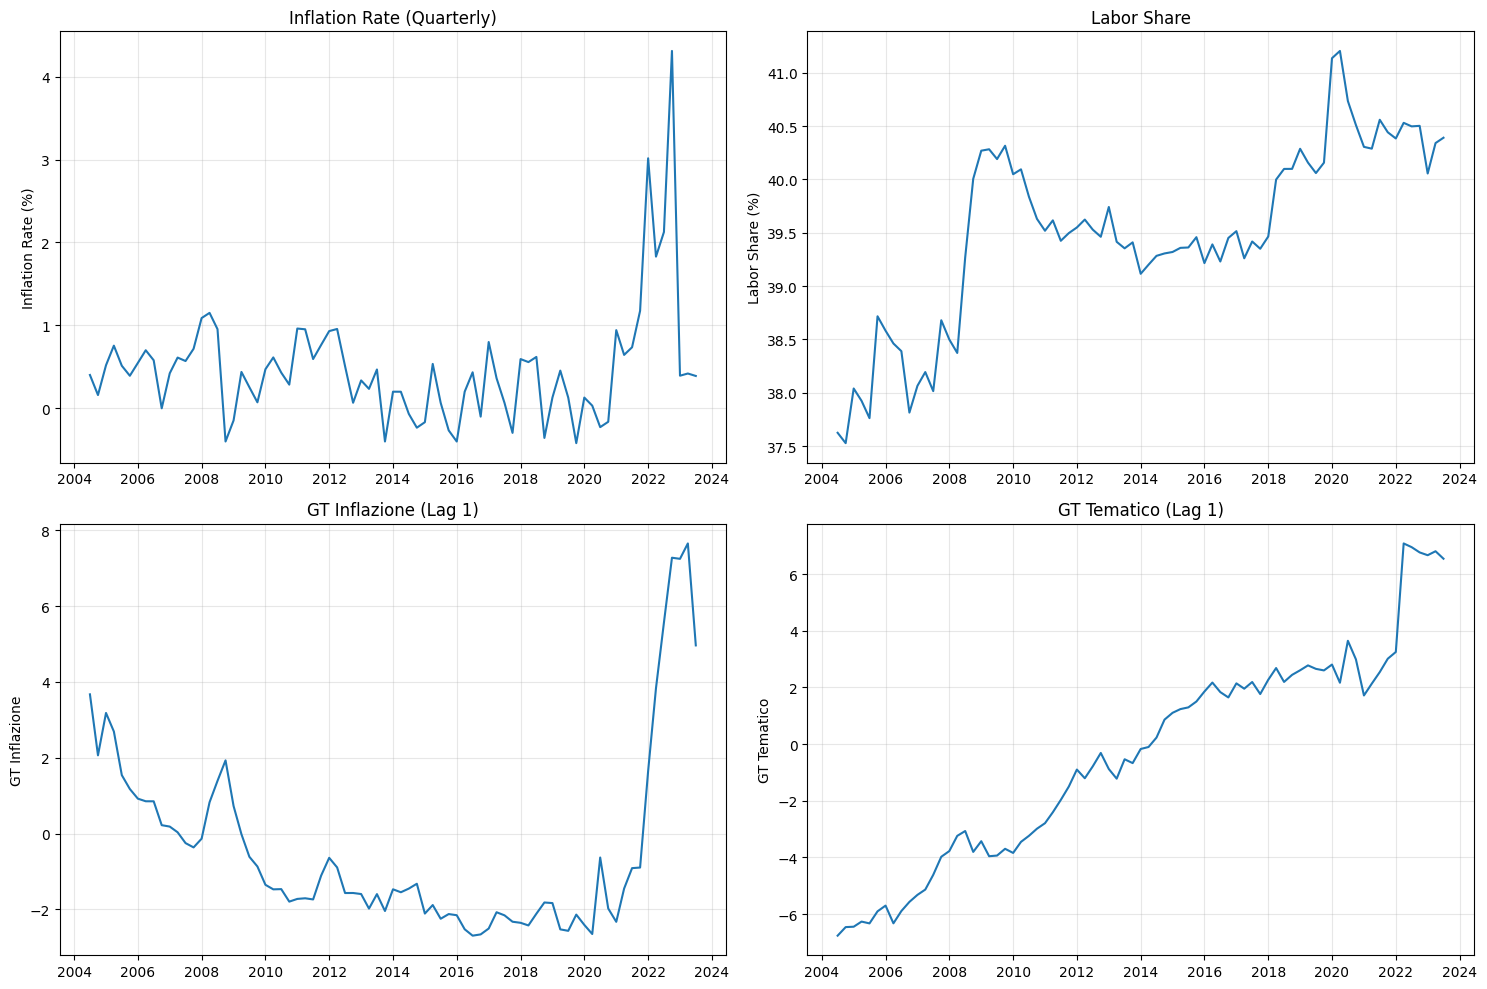


Dataset salvato come: hnkpc_data_final.csv


In [10]:
# Plot delle serie principali
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Inflation Rate
axes[0,0].plot(master_data['DATE'], master_data['INFLATION_RATE'])
axes[0,0].set_title('Inflation Rate (Quarterly)')
axes[0,0].set_ylabel('Inflation Rate (%)')
axes[0,0].grid(True, alpha=0.3)

# Labor Share
axes[0,1].plot(master_data['DATE'], master_data['LABOR_SHARE'])
axes[0,1].set_title('Labor Share')
axes[0,1].set_ylabel('Labor Share (%)')
axes[0,1].grid(True, alpha=0.3)

# GT Inflazione
axes[1,0].plot(master_data['DATE'], master_data['GT_INFLAZIONE_LAG1'])
axes[1,0].set_title('GT Inflazione (Lag 1)')
axes[1,0].set_ylabel('GT Inflazione')
axes[1,0].grid(True, alpha=0.3)

# GT Tematico
axes[1,1].plot(master_data['DATE'], master_data['GT_TEMATICO_LAG1'])
axes[1,1].set_title('GT Tematico (Lag 1)')
axes[1,1].set_ylabel('GT Tematico')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Salva dataset finale
master_data.to_csv('/Users/tommaso/Desktop/tesi-inflation-gt/HNKPC/hnkpc_data_final.csv', index=False)
print("\nDataset salvato come: hnkpc_data_final.csv")


### Step 11: Setup per la stima econometrica

In [11]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
import scipy.stats as stats

# Verifica struttura finale del dataset
print("Dataset finale per HNKPC:")
print(f"Osservazioni: {master_data.shape[0]}")
print("\nVariabili disponibili:")
for i, col in enumerate(master_data.columns):
    print(f"{i+1}. {col}")

# Definisci le variabili per la stima
y = master_data['INFLATION_RATE']  # Variabile dipendente
print(f"\nVariabile dipendente: INFLATION_RATE")
print(f"Osservazioni: {len(y)}")
print(f"Media: {y.mean():.3f}%")
print(f"Std: {y.std():.3f}%")


Dataset finale per HNKPC:
Osservazioni: 77

Variabili disponibili:
1. DATE
2. LABOR_SHARE
3. NIC
4. INFLATION_RATE
5. GT_INFLAZIONE
6. GT_TEMATICO
7. INFLATION_LAG1
8. GT_INFLAZIONE_LAG1
9. GT_TEMATICO_LAG1
10. DUMMY_2022Q1
11. DUMMY_2022Q4

Variabile dipendente: INFLATION_RATE
Osservazioni: 77
Media: 0.484%
Std: 0.714%


### Step 12: Stima HNKPC Base (senza GT)

In [12]:
# HNKPC Base: π_t = λ*LS_t + γ_b*π_{t-1} + dummy + costante + ε_t
X_base = master_data[['LABOR_SHARE', 'INFLATION_LAG1', 'DUMMY_2022Q1', 'DUMMY_2022Q4']].copy()
X_base = sm.add_constant(X_base)  # Aggiungi costante

# Stima modello base
model_base = sm.OLS(y, X_base).fit(cov_type='HAC', cov_kwds={'maxlags': 4})

print("=== HNKPC BASE (senza GT) ===")
print(model_base.summary())

# Salva risultati base
base_results = {
    'aic': model_base.aic,
    'bic': model_base.bic,
    'rsquared': model_base.rsquared,
    'rsquared_adj': model_base.rsquared_adj,
    'fvalue': model_base.fvalue,
    'f_pvalue': model_base.f_pvalue
}

print(f"\nMetriche chiave:")
for key, value in base_results.items():
    if 'pvalue' in key:
        print(f"{key}: {value:.6f}")
    else:
        print(f"{key}: {value:.4f}")


=== HNKPC BASE (senza GT) ===
                            OLS Regression Results                            
Dep. Variable:         INFLATION_RATE   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     1004.
Date:                Wed, 25 Jun 2025   Prob (F-statistic):           1.22e-58
Time:                        16:35:10   Log-Likelihood:                -42.116
No. Observations:                  77   AIC:                             94.23
Df Residuals:                      72   BIC:                             106.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const         

/Users/tommaso/my_python_env/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '


### Step 13: Stima HNKPC con GT Inflazione

In [13]:
# HNKPC + GT Inflazione
X_gt_infl = master_data[['LABOR_SHARE', 'INFLATION_LAG1', 'GT_INFLAZIONE_LAG1', 'DUMMY_2022Q1', 'DUMMY_2022Q4']].copy()
X_gt_infl = sm.add_constant(X_gt_infl)

# Stima modello con GT Inflazione
model_gt_infl = sm.OLS(y, X_gt_infl).fit(cov_type='HAC', cov_kwds={'maxlags': 4})

print("=== HNKPC + GT INFLAZIONE ===")
print(model_gt_infl.summary())

# Salva risultati
gt_infl_results = {
    'aic': model_gt_infl.aic,
    'bic': model_gt_infl.bic,
    'rsquared': model_gt_infl.rsquared,
    'rsquared_adj': model_gt_infl.rsquared_adj,
    'fvalue': model_gt_infl.fvalue,
    'f_pvalue': model_gt_infl.f_pvalue
}

print(f"\nMetriche chiave:")
for key, value in gt_infl_results.items():
    if 'pvalue' in key:
        print(f"{key}: {value:.6f}")
    else:
        print(f"{key}: {value:.4f}")


=== HNKPC + GT INFLAZIONE ===
                            OLS Regression Results                            
Dep. Variable:         INFLATION_RATE   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     678.2
Date:                Wed, 25 Jun 2025   Prob (F-statistic):           9.68e-56
Time:                        16:35:36   Log-Likelihood:                -41.705
No. Observations:                  77   AIC:                             95.41
Df Residuals:                      71   BIC:                             109.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const 

/Users/tommaso/my_python_env/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '


### Step 14: Stima HNKPC con GT Tematico

In [14]:
# HNKPC + GT Tematico
X_gt_tem = master_data[['LABOR_SHARE', 'INFLATION_LAG1', 'GT_TEMATICO_LAG1', 'DUMMY_2022Q1', 'DUMMY_2022Q4']].copy()
X_gt_tem = sm.add_constant(X_gt_tem)

# Stima modello con GT Tematico
model_gt_tem = sm.OLS(y, X_gt_tem).fit(cov_type='HAC', cov_kwds={'maxlags': 4})

print("=== HNKPC + GT TEMATICO ===")
print(model_gt_tem.summary())

# Salva risultati
gt_tem_results = {
    'aic': model_gt_tem.aic,
    'bic': model_gt_tem.bic,
    'rsquared': model_gt_tem.rsquared,
    'rsquared_adj': model_gt_tem.rsquared_adj,
    'fvalue': model_gt_tem.fvalue,
    'f_pvalue': model_gt_tem.f_pvalue
}

print(f"\nMetriche chiave:")
for key, value in gt_tem_results.items():
    if 'pvalue' in key:
        print(f"{key}: {value:.6f}")
    else:
        print(f"{key}: {value:.4f}")


=== HNKPC + GT TEMATICO ===
                            OLS Regression Results                            
Dep. Variable:         INFLATION_RATE   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     264.2
Date:                Wed, 25 Jun 2025   Prob (F-statistic):           7.94e-42
Time:                        16:35:56   Log-Likelihood:                -41.908
No. Observations:                  77   AIC:                             95.82
Df Residuals:                      71   BIC:                             109.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const       

/Users/tommaso/my_python_env/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '


### Step 15: Stima HNKPC con entrambi gli indici GT

In [15]:
# HNKPC + entrambi GT
X_gt_both = master_data[['LABOR_SHARE', 'INFLATION_LAG1', 'GT_INFLAZIONE_LAG1', 'GT_TEMATICO_LAG1', 'DUMMY_2022Q1', 'DUMMY_2022Q4']].copy()
X_gt_both = sm.add_constant(X_gt_both)

# Stima modello con entrambi GT
model_gt_both = sm.OLS(y, X_gt_both).fit(cov_type='HAC', cov_kwds={'maxlags': 4})

print("=== HNKPC + ENTRAMBI GT ===")
print(model_gt_both.summary())

# Salva risultati
gt_both_results = {
    'aic': model_gt_both.aic,
    'bic': model_gt_both.bic,
    'rsquared': model_gt_both.rsquared,
    'rsquared_adj': model_gt_both.rsquared_adj,
    'fvalue': model_gt_both.fvalue,
    'f_pvalue': model_gt_both.f_pvalue
}

print(f"\nMetriche chiave:")
for key, value in gt_both_results.items():
    if 'pvalue' in key:
        print(f"{key}: {value:.6f}")
    else:
        print(f"{key}: {value:.4f}")


=== HNKPC + ENTRAMBI GT ===
                            OLS Regression Results                            
Dep. Variable:         INFLATION_RATE   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     369.7
Date:                Wed, 25 Jun 2025   Prob (F-statistic):           7.35e-49
Time:                        16:36:20   Log-Likelihood:                -41.492
No. Observations:                  77   AIC:                             96.98
Df Residuals:                      70   BIC:                             113.4
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const   

/Users/tommaso/my_python_env/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 5
  warnings.warn('covariance of constraints does not have full '


### Step 16: Confronto risultati

In [16]:
# Tabella comparativa
results_comparison = pd.DataFrame({
    'Base': base_results,
    'GT_Inflazione': gt_infl_results,
    'GT_Tematico': gt_tem_results,
    'GT_Entrambi': gt_both_results
})

print("=== CONFRONTO RISULTATI HNKPC ===")
print(results_comparison.round(4))

# Test di significatività del miglioramento
print("\n=== TEST DI SIGNIFICATIVITA' ===")

# Test F per modelli nested
from scipy.stats import f

def nested_f_test(model_restricted, model_unrestricted):
    """Test F per modelli nested"""
    rss_r = model_restricted.ssr
    rss_u = model_unrestricted.ssr
    df_r = model_restricted.df_resid
    df_u = model_unrestricted.df_resid
    
    f_stat = ((rss_r - rss_u) / (df_r - df_u)) / (rss_u / df_u)
    p_value = 1 - f.cdf(f_stat, df_r - df_u, df_u)
    
    return f_stat, p_value

# Test Base vs GT_Inflazione
f_stat, p_val = nested_f_test(model_base, model_gt_infl)
print(f"Base vs GT_Inflazione - F-stat: {f_stat:.4f}, p-value: {p_val:.4f}")

# Test Base vs GT_Tematico
f_stat, p_val = nested_f_test(model_base, model_gt_tem)
print(f"Base vs GT_Tematico - F-stat: {f_stat:.4f}, p-value: {p_val:.4f}")

# Test Base vs GT_Entrambi
f_stat, p_val = nested_f_test(model_base, model_gt_both)
print(f"Base vs GT_Entrambi - F-stat: {f_stat:.4f}, p-value: {p_val:.4f}")


=== CONFRONTO RISULTATI HNKPC ===
                   Base  GT_Inflazione  GT_Tematico  GT_Entrambi
aic             94.2323        95.4091      95.8152      96.9835
bic            105.9513       109.4720     109.8780     113.3901
rsquared         0.6524         0.6561       0.6542       0.6580
rsquared_adj     0.6331         0.6318       0.6299       0.6286
fvalue        1004.0075       678.2310     264.2120     369.7090
f_pvalue         0.0000         0.0000       0.0000       0.0000

=== TEST DI SIGNIFICATIVITA' ===
Base vs GT_Inflazione - F-stat: 0.7631, p-value: 0.3853
Base vs GT_Tematico - F-stat: 0.3857, p-value: 0.5366
Base vs GT_Entrambi - F-stat: 0.5723, p-value: 0.5669
